<a href="https://colab.research.google.com/github/ngotancuong/PythonAssignment/blob/main/Baitap01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BÀI HƯỚNG DẪN TÌM HIỂU VỀ EDA, PHÂN TÍCH DỮ LIỆU CHUỖI THỜI GIAN VÀ CÁC DỰ BÁO DỰA VÀO MÔ HÌNH SARIMAX

Cuộc thi này do Walmart tài trợ có tên là Dự báo M5. Sử dụng dữ liệu bao gồm khoảng 30.000 mặt hàng khác nhau trong gần 1900 ngày. Mục tiêu là dự báo doanh số bán hàng trong 28 ngày tới. Phân bố ở ba Tiểu bang Hoa Kỳ (California, Texas và Wisconsin).

### Đầu tiên phải load data mẫu từ Kaggle về project này để chạy

In [1]:
# Cài đặt package Kaggle hỗ trợ kết nối Colab với Kaggle
!pip install -q kaggle

In [2]:
# Download file Kaggle API Token cho phép kết nối vào tài nguyên Kaggle
!wget 'https://raw.githubusercontent.com/ngotancuong/PythonAssignment/main/kaggle.json'

# Cách khác nếu đã download file kaggle.json về máy tính rồi thì dùng lệnh sau để upload thủ công lên Colab
# from google.colab import files
# files.upload()

--2022-10-19 18:40:03--  https://raw.githubusercontent.com/ngotancuong/PythonAssignment/main/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      63  --.-KB/s    in 0s      

2022-10-19 18:40:03 (2.98 MB/s) - ‘kaggle.json’ saved [63/63]



In [3]:
# Bắt buộc file kaggle.json phải được đặt tại đường dẫn ~/.kaggle/kaggle.json để dùng API
# Tạo thư mục
!mkdir ~/.kaggle

In [4]:
# Copy file kaggle.json vào thư mục quy định
!cp kaggle.json ~/.kaggle/

In [5]:
# Phân quyền trên file là Owner được read & write
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# List 1 số datasets thông dụng trên Kaggle
!kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                      9KB  2022-10-06 08:55:25           4092        127  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset               11KB  2022-09-30 04:05:11           3398         98  1.0              
thedevastator/fast-food-restaurants-in-the-united-states        Fast Food Restaurants in the United States            4MB  2022-10-08 17:30:38           1171         32  1.0              
whenamancodes/students-performance-in-exams                 

Nếu không thấy dataset mình cần thì tìm trực tiếp trên Kaggle. Vào mục Data như hình, copy code thực thi
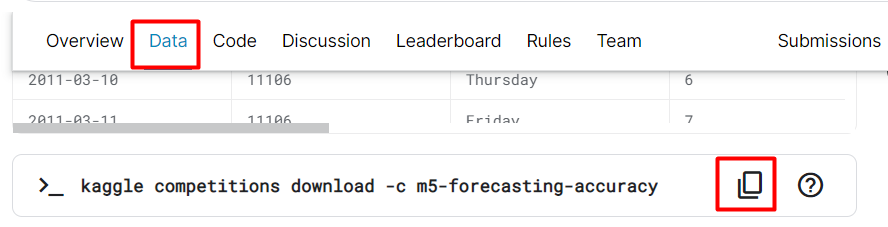

In [7]:
# Tiến hành download dataset về Colab
!kaggle competitions download -c m5-forecasting-accuracy

 74% 34.0M/45.8M [00:00<00:00, 186MB/s]
100% 45.8M/45.8M [00:00<00:00, 171MB/s]


In [22]:
#Tạo folder chứa dataset, thông số -p -v để tạo folder cha và con
!mkdir -p -v /kaggle/input/m5-forecasting-accuracy

mkdir: created directory '/kaggle'
mkdir: created directory '/kaggle/input'
mkdir: created directory '/kaggle/input/m5-forecasting-accuracy'


In [23]:
# Giải nén file datatset vào folder
!unzip  m5-forecasting-accuracy.zip -d "/kaggle/input/m5-forecasting-accuracy"
# Hoàn thành xong bước chuẩn bị dữ liệu

Archive:  m5-forecasting-accuracy.zip
  inflating: /kaggle/input/m5-forecasting-accuracy/calendar.csv  
  inflating: /kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv  
  inflating: /kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv  
  inflating: /kaggle/input/m5-forecasting-accuracy/sample_submission.csv  
  inflating: /kaggle/input/m5-forecasting-accuracy/sell_prices.csv  


### Import các thư viện cần thiết

In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import time
import math
import datetime


# Import widgets
from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display

from math import log, floor
from sklearn.neighbors import KDTree

import seaborn as sns
sns.set_style('whitegrid')

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

import itertools
from itertools import cycle
plt.style.use('seaborn')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
# Kiểm tra đường dẫn các file Dataset, đảm bảo truy cập thành công

/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv


#### Mô tả các Dataset:

Các file dataset đã import vào có những nội dung như sau

* `calendar_df.csv` - Chứa thông tin về ngày sản phẩm được bán và cũng chứa thông tin về các ngày lễ và các dịp đặc biệt.
* `train_sales_df.csv` - Chứa dữ liệu lịch sử bán hàng hàng ngày tại từng cửa hàng trong khoảng 1900 ngày [d_1 - d_1913] 
* `submission_file.csv` - Những file submit đúng định dạng, bao gồm product ids, column ids cho việc dự báo doanh thu bán hàng 28 ngày kế tiếp. 
* `sell_prices_df.csv` - Bao gồm thông tin về giá sản phẩm được bán tại từng cửa hàng mỗi ngày.
* `sales_train_evaluation.csv` - Bao gồm doanh số [d_1 - d_1941] (dùng cho việc khen thưởng, tuyên dương nhân viên)

### Đọc các Datasets vào bộ nhớ chính:

In [25]:
sell_prices_df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
train_sales_df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
calendar_df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
submission_file = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sample_submission.csv')

### Xem thử các Dataset có chứa gì

In [26]:
sell_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [27]:
train_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [28]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


Chúng ta có thể thấy `sell_prices_df` chứa đến 6.841.121 giao dịch ở cấp độ cửa hàng. `train_sales_df` chứa 30.490 sản phẩm khác nhau. Và `calendar_df' có thể dùng để phân tích theo chuỗi thời gian các sản phẩm đã bán.

### EDA (Exploratory Data Analysis) - Khám phá việc phân tích dữ liệu

#### Các câu hỏi về phân phối sản phẩm và hành vi theo thời gian

In [29]:
# Lấy ra 3 dòng đầu tiên của Data Frame để xem nó chứa dữ liệu gì để khai thác
train_sales_df.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [38]:
# Trả về danh sách các tiêu đề cột có chứa tiền tố 'd_' (tức là cột ngày)
d_cols = [c for c in train_sales_df.columns if 'd_' in c]
# Tổng số ngày bán hàng được tính là sum của các cột (axis=1 là đếm ngang)
train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1)
# train_sales_df[d_cols] là dataframe chứa các cột và dòng dữ liệu ngày bán hàng
# Hàm mean là tính giá trị trung bình
train_sales_df['avg_sales_all_days'] = train_sales_df[d_cols].mean(axis = 1)
# Hàm median là tính giá trị trung vị
train_sales_df['median_sales_all_days'] = train_sales_df[d_cols].median(axis = 1)
#train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

#### Biểu đồ product_id theo categoty

In [40]:
# Data Frame gom nhóm id theo cat_id và đếm số lượng từng id trong cat_id tương ứng
df = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
# Hàm vẽ biểu đồ hình bánh
fig = px.pie(df, values='total_entries', names='cat_id', 
            color_discrete_sequence=px.colors.sequential.RdBu,
            width = 750, height=450, title = 'Distribution of Product_IDs Across Categories')
fig.show()

Thực phẩm là mặt hàng bán chạy nhất, tiếp theo là đồ gia dụng và sau đó là đồ sở thích.

In [41]:
df = train_sales_df.groupby(['state_id'])['total_sales_all_days'].sum().reset_index()
fig = px.pie(df, values='total_sales_all_days', names='state_id', 
            color_discrete_sequence=px.colors.sequential.Aggrnyl,
            width = 750, height=450, title = 'Distribution of Total_Sales Across States')
fig.show()

Tổng số lượng hàng bán ở Bang CA là cao nhất, kế tiếp là Texas và Wisconsin

In [42]:
# Đếm số lượng id theo từng cat_id và lưu vào data frame
df1 = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
# Tính tổng doanh số theo cat_id và state_id, lưu vào data frame
df2 = train_sales_df.groupby(['cat_id', 'state_id'])['total_sales_all_days'].sum().reset_index()

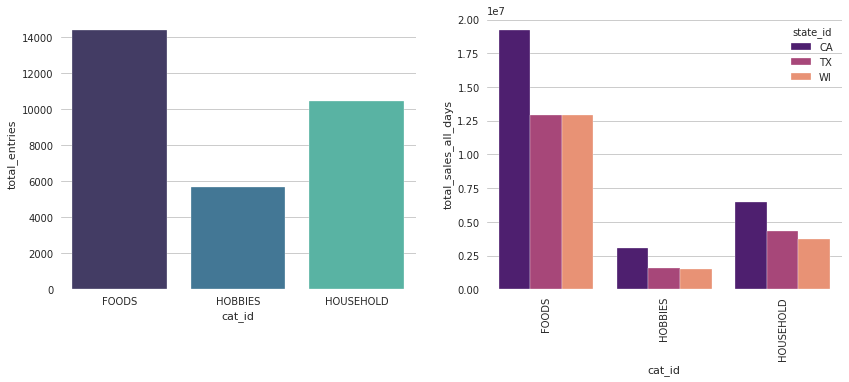

In [43]:
# Dùng module seaborn để vẽ biểu đồ hình cột 
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

sns.barplot(x = 'cat_id', y='total_entries', data=df1, 
            palette='mako', ax=ax1)
sns.barplot(x = 'cat_id', y='total_sales_all_days', hue='state_id', data=df2, 
            palette='magma', ax=ax2)

plt.xticks(rotation=90)
plt.show()